# C1 W2 Group 8

In [17]:
import pickle
from src.paths import BBDD_PATH, QSD1_W3_PATH, QSD1_NON_AUGMENTED_W3_PATH, WEEK_3_PATH, WEEK_3_RESULTS_PATH
from PIL import Image, ImageDraw
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from scipy.signal import wiener
from tqdm import tqdm
from itertools import product

## Data loading

In [2]:
database_image_PIL_list = [Image.open(db_img_path) for db_img_path in sorted(BBDD_PATH.glob("*.jpg"))]  # Load once
for idx, db_img in enumerate(database_image_PIL_list):
    assert db_img.filename.endswith(f"{idx}.jpg")

In [3]:
print(QSD1_W3_PATH)
query_d1_image_PIL_list = [Image.open(query_img_path) for query_img_path in sorted(QSD1_W3_PATH.glob("*.jpg"))]  # Load once
for idx, query_img in enumerate(query_d1_image_PIL_list):
    assert query_img.filename.endswith(f"{idx}.jpg")

C:\Users\Albert Roca\Documents\MCV\C1 Image UPC\Project\Team8\data\qsd1_w3


In [4]:
non_augmented_d1_image_PIL_list = [Image.open(query_img_path) for query_img_path in sorted(QSD1_NON_AUGMENTED_W3_PATH.glob("*.jpg"))]  # Load once
for idx, query_img in enumerate(non_augmented_d1_image_PIL_list):
    assert query_img.filename.endswith(f"{idx}.jpg")

In [5]:
noisy_images_d1 = []
noisy_images_indexes_d1 = []
augmentations = []
with (QSD1_W3_PATH / "augmentations.pkl").open('rb') as f:
    augmentations = pickle.load(f)
    for idx, img in enumerate(augmentations):
        if img != 'None':
            noisy_images_d1.append(query_d1_image_PIL_list[idx])
            noisy_images_indexes_d1.append(idx)

## Task 1: Noise filtering

In [6]:
# Utility functions to handle RGB images
def split_channels(image):
    """Split RGB image into its three color channels."""
    return cv2.split(image)

def merge_channels(channels):
    """Merge the denoised RGB channels back together and clip to valid range [0, 255]."""
    merged_image = cv2.merge(channels)
    return np.clip(merged_image, 0, 255).astype(np.uint8)

# --- Linear Filters ---

def gaussian_blur(image, kernel_size=(3, 3)):
    channels = split_channels(image)
    denoised_channels = [cv2.GaussianBlur(channel, kernel_size, 0) for channel in channels]
    return merge_channels(denoised_channels)

def mean_filter(image, kernel_size=(3, 3)):
    channels = split_channels(image)
    denoised_channels = [cv2.blur(channel, kernel_size) for channel in channels]
    return merge_channels(denoised_channels)

def wiener_filter(image, kernel_size=3):
    channels = split_channels(image)
    denoised_channels = []
    
    for channel in channels:
        denoised_channel = wiener(channel, kernel_size)
        denoised_channel[np.isnan(denoised_channel)] = 0 
        denoised_channel[denoised_channel < 0] = 0  
        denoised_channels.append(denoised_channel)
    
    return merge_channels(denoised_channels)

# --- Non-Linear Filters ---

def median_filter(image, kernel_size=3):
    channels = split_channels(image)
    denoised_channels = [cv2.medianBlur(channel, kernel_size) for channel in channels]
    return merge_channels(denoised_channels)

def bilateral_filter(image, diameter=5, sigma_color=25, sigma_space=25):
    channels = split_channels(image)
    denoised_channels = [cv2.bilateralFilter(channel, diameter, sigma_color, sigma_space) for channel in channels]
    return merge_channels(denoised_channels)

def non_local_means_filter(image, h=0.6, patch_size=3, patch_distance=5, fast_mode=True):
    sigma_est = np.mean([estimate_sigma(image[..., channel], channel_axis=None) for channel in range(image.shape[-1])])
    denoised_image = denoise_nl_means(image, h=h * sigma_est, 
                                      patch_size=patch_size, 
                                      patch_distance=patch_distance,
                                      channel_axis=-1, fast_mode=fast_mode)
    return merge_channels([denoised_image[..., i] * 255 for i in range(denoised_image.shape[-1])])

In [7]:
def evaluate_image_quality(denoised_image, ground_truth):
    psnr_value = psnr(ground_truth, denoised_image, data_range=255)
    ssim_value, _ = ssim(ground_truth, denoised_image, full=True, channel_axis=-1)
    return psnr_value, ssim_value

### Grid search
We perform a grid search to find the optimal parameters for each of the filters, evaluating it with the noisy images of `qsd1`.

In [24]:
# Denoising methods with parameter exploration
def plot_results(metric_values, methods_names, metric_name, params):
    #  Convert tuple params like (3, 3) into single values like 3, 5, 7
    kernel_sizes = [param[0] for param in params]
    num_methods = len(methods_names)
    plt.figure(figsize=(10, 6))
    bar_width = 0.15
    indices = np.arange(len(kernel_sizes))

    for i, method in enumerate(methods_names):
        plt.bar(indices + i * bar_width, metric_values[i], bar_width, label=method)

    # Add labels and title
    plt.xlabel('Kernel Sizes')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} for Denoising Methods with Different Kernel Sizes')
    plt.xticks(indices + bar_width * (num_methods - 1) / 2, kernel_sizes)
    plt.legend()
    plt.tight_layout()
    plt.show()
    

def explore_filter(filter_func, param_combinations, image, ground_truth):
    psnr_values, ssim_values = [], []
    best_psnr, best_ssim, best_params = -float('inf'), -float('inf'), None
    for params in param_combinations:
        denoised_image = filter_func(image, *params)
        psnr_value, ssim_value = evaluate_image_quality(denoised_image, ground_truth)
        psnr_values.append(psnr_value)
        ssim_values.append(ssim_value)
        if psnr_value > best_psnr and ssim_value > best_ssim:
            best_psnr, best_ssim, best_params = psnr_value, ssim_value, params
    return best_params, best_psnr, best_ssim, psnr_values, ssim_values, param_combinations

def explore_gaussian_blur(image, ground_truth, kernel_sizes):
    return explore_filter(gaussian_blur, [(k,) for k in kernel_sizes], image, ground_truth)

def explore_mean_filter(image, ground_truth, kernel_sizes):
    return explore_filter(mean_filter, [(k,) for k in kernel_sizes], image, ground_truth)

def explore_wiener_filter(image, ground_truth, kernel_sizes):
    return explore_filter(wiener_filter, [(k,) for k in kernel_sizes], image, ground_truth)

def explore_median_filter(image, ground_truth, kernel_sizes):
    return explore_filter(median_filter, [(k,) for k in kernel_sizes], image, ground_truth)

def explore_bilateral_filter(image, ground_truth, diameters, sigma_colors, sigma_spaces):
    return explore_filter(bilateral_filter, product(diameters, sigma_colors, sigma_spaces), image, ground_truth)

def explore_nl_means_filter(image, ground_truth, h_values, patch_sizes, patch_distances):
    return explore_filter(non_local_means_filter, product(h_values, patch_sizes, patch_distances), image, ground_truth)


# Explore all methods and return the best parameters
def explore_all_methods(image, ground_truth):
    # Parameter ranges for each method
    kernel_sizes = [(1,1), (3, 3), (5, 5), (7, 7), (9, 9), (11, 11)]

    diameters = [5, 9, 13, 17, 21]
    sigma_colors = [25, 50, 75, 100, 125]
    sigma_spaces = [25, 50, 75, 100, 125]
    h_values = [0.6, 0.8, 1.0, 1.2, 1.5]
    patch_sizes = [3, 5, 7, 9, 11]
    patch_distances = [5, 6, 8, 11, 17]

    all_results = {}
    best_results = {}

    # Explore each denoising method
    all_results['Gaussian'] = explore_gaussian_blur(image, ground_truth, kernel_sizes)
    best_results['Gaussian'] = all_results['Gaussian'][0:3]
    all_results['Mean'] = explore_mean_filter(image, ground_truth, kernel_sizes)
    best_results['Mean'] = all_results['Mean'][0:3]
    all_results['Wiener'] = explore_wiener_filter(image, ground_truth, kernel_sizes)
    best_results['Wiener'] = all_results['Wiener'][0:3]
    all_results['Median'] = explore_median_filter(image, ground_truth, kernel_sizes)
    best_results['Median'] = all_results['Median'][0:3]
    '''all_results['Bilateral'] = explore_bilateral_filter(image, ground_truth, diameters, sigma_colors, sigma_spaces)
    best_results['Bilateral'] = all_results['Bilateral'][0:3]
    all_results['NLM'] = explore_nl_means_filter(image, ground_truth, h_values, patch_sizes, patch_distances)
    best_results['NLM'] = all_results['NLM'][0:3]'''
    
    methods = []
    psnr_results = []
    ssim_results = []
    for method_name, result in all_results.items():
        if method_name in ['Gaussian', 'Mean', 'Wiener', 'Median']:
            methods.append(method_name)
            psnr_results.append(result[3])
            ssim_results.append(result[4])

    df_results = pd.DataFrame.from_dict(best_results, orient='index', columns=['Best Parameters', 'Best PSNR', 'Best SSIM'])
    
    # Uncomment to display the results for each image
    plot_results(psnr_results, methods, "PSNR", kernel_sizes)
    #plot_results(ssim_results, methods, "SSIM", kernel_sizes)
    #display(df_results)
    return df_results

# Set to True to explore all parameters, omitted to make execution faster
if False:
    methods_names = ['Gaussian', 'Mean', 'Wiener', 'Median', 'Bilateral', 'NLM']
    for noisy_idx, noisy_img in zip(noisy_images_indexes_d1, noisy_images_d1):
        print("Image index: ", noisy_idx)
        print("Augmentation: ",  augmentations[noisy_idx])
        image = np.array(noisy_img)  # Noisy image
        ground_truth = np.array(non_augmented_d1_image_PIL_list[noisy_idx])  # Ground truth image
        df_out = explore_all_methods(image, ground_truth)

#### Conclusions of optimal filter parameters

What we have found is that it depends a lot on the image the selection of the filter and the kernel size. However, observing the plots below we can observe that in the cases in which an Impulse Noise has been added, in most of the cases the best working filter to remove the noise is the Median with kernel size 3x3. Therefore, we consider it to be the optimal one.

### Denoising QSD1

In this part we filter all the images with all the filters and the optimal parameters we found by the grid search method, despite the variance of the parameters depending on the image. Then we compute the averages over all the metrics.

In [25]:
# Applying the filters to all the images
q_results_gaussian = []
q_results_mean = []
q_results_wiener = []
q_results_median = []
q_results_bilateral = []
q_results_nl_means = []

for q_img in tqdm(query_d1_image_PIL_list):
    q_img_np = np.array(q_img) 
    q_results_gaussian.append(gaussian_blur(q_img_np))
    q_results_mean.append(mean_filter(q_img_np))
    q_results_wiener.append(wiener_filter(q_img_np))
    q_results_median.append(median_filter(q_img_np))
    q_results_bilateral.append(bilateral_filter(q_img_np))
    q_results_nl_means.append(non_local_means_filter(q_img_np))

  0%|          | 0/30 [00:00<?, ?it/s]c:\Users\Albert Roca\Documents\MCV\C1 Image UPC\Project\Team8\venv\Lib\site-packages\scipy\signal\_signaltools.py:1647: RuntimeWarning: divide by zero encountered in divide
  res *= (1 - noise / lVar)
c:\Users\Albert Roca\Documents\MCV\C1 Image UPC\Project\Team8\venv\Lib\site-packages\scipy\signal\_signaltools.py:1647: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)
100%|██████████| 30/30 [00:49<00:00,  1.64s/it]


In [26]:
def plot_images_with_multiple_filters(original_images, noisy_images, results_gaussian, results_mean, 
                                      results_wiener, results_median, 
                                      results_bilateral, results_nl_means):
    num_images = len(original_images)
    num_methods = 6 
    fig, axes = plt.subplots(num_images, num_methods + 2, figsize=(25, 5 * num_images))  # +1 for original image

    for i in range(num_images):
        original_image = original_images[i]
        noisy_image = noisy_images[i]

        axes[i, 0].imshow(original_image)
        axes[i, 0].set_title(f'Original Image {i+1}')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(noisy_image)
        axes[i, 1].set_title(f'Noisy image Image {i+1}')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(results_gaussian[i])
        axes[i, 2].set_title(f'Gaussian Denoised {i+1}')
        axes[i, 2].axis('off')

        axes[i, 3].imshow(results_mean[i])
        axes[i, 3].set_title(f'Mean Denoised {i+1}')
        axes[i, 3].axis('off')

        axes[i, 4].imshow(results_wiener[i])
        axes[i, 4].set_title(f'Wiener Denoised {i+1}')
        axes[i, 4].axis('off')

        axes[i, 5].imshow(results_median[i])
        axes[i, 5].set_title(f'Median Denoised {i+1}')
        axes[i, 5].axis('off')

        axes[i, 6].imshow(results_bilateral[i])
        axes[i, 6].set_title(f'Bilateral Denoised {i+1}')
        axes[i, 6].axis('off')

        axes[i, 7].imshow(results_nl_means[i])
        axes[i, 7].set_title(f'NLM Denoised {i+1}')
        axes[i, 7].axis('off')

    plt.tight_layout()
    plt.savefig(WEEK_3_PATH / 'results' / 'denoised_images_plot.png')
    plt.close()


plot_images_with_multiple_filters(non_augmented_d1_image_PIL_list, query_d1_image_PIL_list, q_results_gaussian, 
                                  q_results_mean, q_results_wiener, 
                                  q_results_median, q_results_bilateral, 
                                  q_results_nl_means)


In [27]:
def evaluate_results(ground_truth_images, results_gaussian, results_mean, 
                     results_wiener, results_median, results_bilateral, results_nl_means):
    metrics = []
    num_images = len(ground_truth_images)

    for i in tqdm(range(num_images)):
        ground_truth = np.array(ground_truth_images[i])

        # Evaluate each denoising method
        psnr_gaussian, ssim_gaussian = evaluate_image_quality(results_gaussian[i], ground_truth)
        psnr_mean, ssim_mean = evaluate_image_quality(results_mean[i], ground_truth)
        psnr_wiener, ssim_wiener = evaluate_image_quality(results_wiener[i], ground_truth)
        psnr_median, ssim_median = evaluate_image_quality(results_median[i], ground_truth)
        psnr_bilateral, ssim_bilateral = evaluate_image_quality(results_bilateral[i], ground_truth)
        psnr_nl_means, ssim_nl_means = evaluate_image_quality(results_nl_means[i], ground_truth)

        # Collect the results for each image
        metrics.append({
            "Image": f"Image {i+1}",
            "PSNR (Gaussian)": psnr_gaussian,
            "SSIM (Gaussian)": ssim_gaussian,
            "PSNR (Mean)": psnr_mean,
            "SSIM (Mean)": ssim_mean,
            "PSNR (Wiener)": psnr_wiener,
            "SSIM (Wiener)": ssim_wiener,
            "PSNR (Median)": psnr_median,
            "SSIM (Median)": ssim_median,
            "PSNR (Bilateral)": psnr_bilateral,
            "SSIM (Bilateral)": ssim_bilateral,
            "PSNR (NLM)": psnr_nl_means,
            "SSIM (NLM)": ssim_nl_means,
        })

    df_results = pd.DataFrame(metrics)
    
    return df_results

In [28]:
df_results_all = evaluate_results(non_augmented_d1_image_PIL_list, q_results_gaussian, q_results_mean, 
                              q_results_wiener, q_results_median, q_results_bilateral, 
                              q_results_nl_means)

100%|██████████| 30/30 [01:39<00:00,  3.32s/it]


In [29]:
df_results_noisy = df_results_all[df_results_all['Image'].isin([f"Image {i+1}" for i in noisy_images_indexes_d1])]

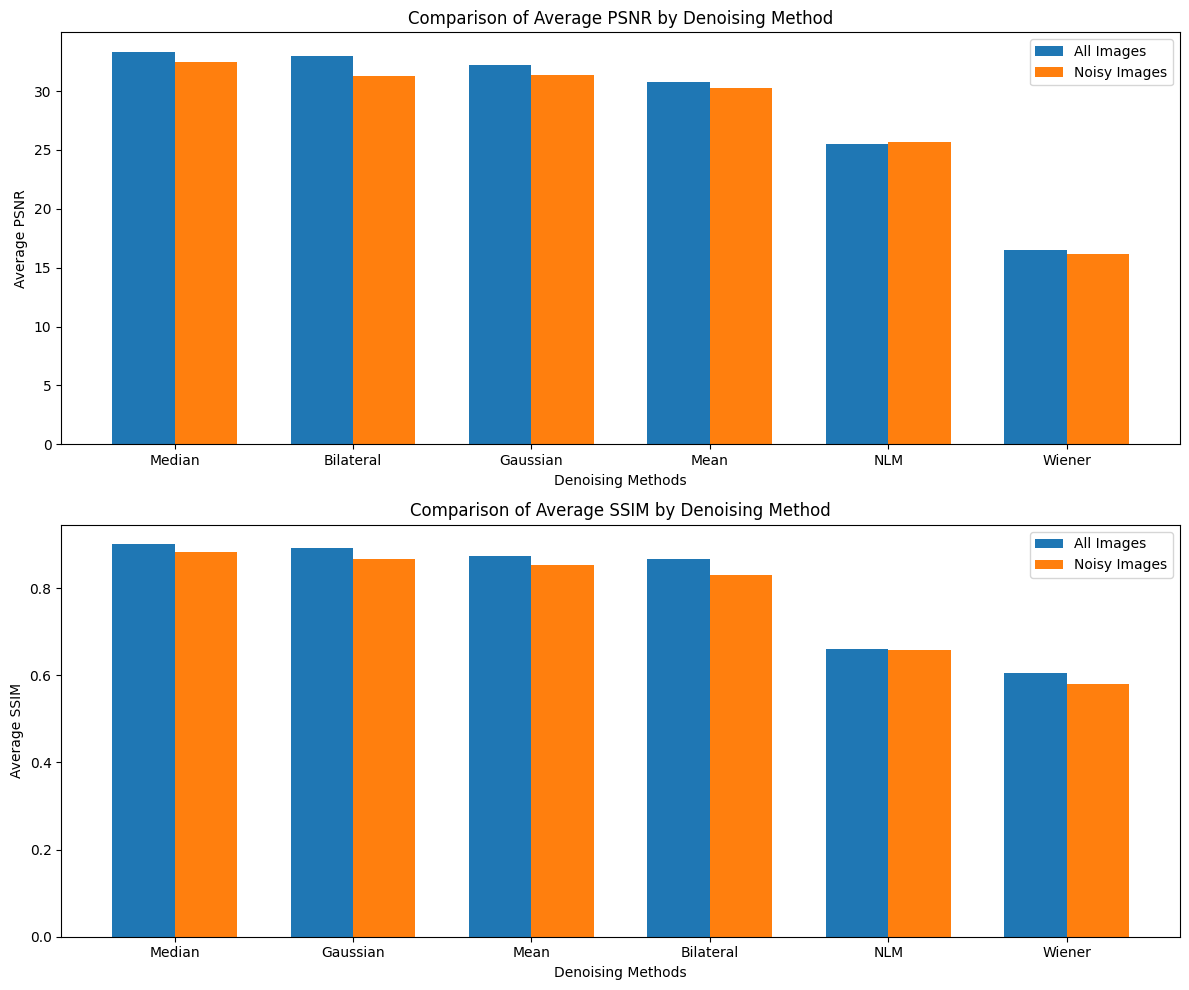

In [30]:
def plot_metrics_bar(df_results_all=None, df_results_noisy=None, methods=None):
    # Calculate the average PSNR and SSIM for each method
    avg_psnr_all = [df_results_all[f"PSNR ({method})"].mean() for method in methods]
    avg_ssim_all = [df_results_all[f"SSIM ({method})"].mean() for method in methods]
    avg_psnr_noisy = [df_results_noisy[f"PSNR ({method})"].mean() for method in methods]
    avg_ssim_noisy = [df_results_noisy[f"SSIM ({method})"].mean() for method in methods]

    psnr_data = list(zip(methods, avg_psnr_all, avg_psnr_noisy))
    psnr_data.sort(key=lambda x: x[1] + x[2], reverse=True)  # Sort by the sum of PSNR values from all and noisy
    sorted_methods_psnr, sorted_psnr_all, sorted_psnr_noisy = zip(*psnr_data)
    ssim_data = list(zip(methods, avg_ssim_all, avg_ssim_noisy))
    ssim_data.sort(key=lambda x: x[1] + x[2], reverse=True)  # Sort by the sum of SSIM values from all and noisy
    sorted_methods_ssim, sorted_ssim_all, sorted_ssim_noisy = zip(*ssim_data)
    positions = np.arange(len(methods))
    bar_width = 0.35
    fig, ax = plt.subplots(2, 1, figsize=(12, 10))

    # Bar Plot for PSNR
    ax[0].bar(positions - bar_width/2, sorted_psnr_all, bar_width, label='All Images')
    ax[0].bar(positions + bar_width/2, sorted_psnr_noisy, bar_width, label='Noisy Images')
    ax[0].set_xlabel('Denoising Methods')
    ax[0].set_ylabel('Average PSNR')
    ax[0].set_title('Comparison of Average PSNR by Denoising Method')
    ax[0].set_xticks(positions)
    ax[0].set_xticklabels(sorted_methods_psnr)
    ax[0].legend()

    # Bar Plot for SSIM
    ax[1].bar(positions - bar_width/2, sorted_ssim_all, bar_width, label='All Images')
    ax[1].bar(positions + bar_width/2, sorted_ssim_noisy, bar_width, label='Noisy Images')
    ax[1].set_xlabel('Denoising Methods')
    ax[1].set_ylabel('Average SSIM')
    ax[1].set_title('Comparison of Average SSIM by Denoising Method')
    ax[1].set_xticks(positions)
    ax[1].set_xticklabels(sorted_methods_ssim)
    ax[1].legend()

    plt.tight_layout()
    plt.show()

methods_names = ["Gaussian", "Mean", "Wiener", "Median", "Bilateral", "NLM"]
plot_metrics_bar(df_results_all, df_results_noisy, methods_names)


In [15]:
# Given the previous results we set the optimal denoised images
query_d1_denoised_images = q_results_median

#### Conclusions after denoising QSD1

As we can observe, the best performing denoising filter is the Median, achieving the highest PSNR and SSIM, with a Kernel size of 3x3. However, the Gaussian performance is extremely close to the Median, as we saw in the previous analysis.

In [18]:
mean_row = df_results_all.mean(numeric_only=True)
mean_row['Image'] = 'Average'
mean_row_df = pd.DataFrame([mean_row])
df_results_all_final = pd.concat([df_results_all, mean_row_df], ignore_index=True)
df_results_all_final.to_csv(WEEK_3_RESULTS_PATH/"metrics_all.csv", index=False, decimal=",")

In [19]:
mean_row = df_results_noisy.mean(numeric_only=True)
mean_row['Image'] = 'Average'
mean_row_df = pd.DataFrame([mean_row])
df_results_noisy_final = pd.concat([df_results_noisy, mean_row_df], ignore_index=True)
df_results_noisy_final.to_csv(WEEK_3_RESULTS_PATH/"metrics_noisy.csv", index=False, decimal=",")

## Task 2: Texture descriptors
All descriptors of the project have been implemented in `src/descriptors.py`.


In [20]:
from src.descriptors import LBPDescriptor, DCTDescriptor, WaveletDescriptor

In [21]:
texture_descriptors_functions = [
    LBPDescriptor(num_points=24, radius=8), 
    DCTDescriptor(), 
    WaveletDescriptor(wavelet='db1', level=2),
    
]

In [22]:
descriptors_qsd1 = {}
for descriptor_func in texture_descriptors_functions:
    descriptors_qsd1[descriptor_func.__class__.__name__] = []
    for image in query_d1_denoised_images:
        descriptors_qsd1[descriptor_func.__class__.__name__].append(descriptor_func.compute(image))